# Multimodal Retrieval-Augmented Generation (RAG) with Llama-index

The goal of this notebook is to use Llamaindex to perform multimodal RAG based on images (in a local folder) and text (from a Notion database). I used [this tutorial](https://www.youtube.com/watch?v=35RlrrgYDyU) as a reference.

The code can be generalized for any application where you need to retrieve documents from multiple data sources. To incorporate data other than Notion or images, simply select other [Readers from the Llama Hub](https://llamahub.ai/?tab=readers), load them, and add them to the "all_documents" variable.

An illustration of the workflow (not the exact one, but close) is available below.

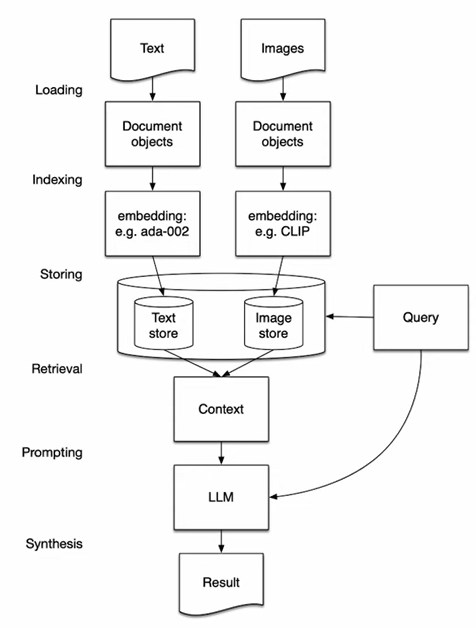

### Installing and importing dependencies

In [ ]:
!pip install llama-index --q
!pip install llama-index-llms-openai -q
!pip install llama-index-readers-notion --q
!pip install llama-index-multi-modal-llms-openai -q
!pip install llama-index-vector-stores-qdrant --q
!pip install qdrant_client --q
!pip install llama-index-embeddings-clip --q
!pip install git+https://github.com/openai/CLIP.git --q
!pip install torch torchvision --q
!pip install matplotlib --q
!pip install openai --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.0/326.0 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from llama_index.core import Document, VectorStoreIndex, SimpleDirectoryReader
from llama_index.readers.notion import NotionPageReader
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import PromptTemplate
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext
import qdrant_client
from PIL import Image
import matplotlib.pyplot as plt
import os
from pprint import pprint

### Setting up keys

For using GPT, you will need an OpenAI key (you can also use other models). For using Notion, you will need both an [integration token](https://www.notion.so/help/create-integrations-with-the-notion-api) and a [database ID](https://developers.notion.com/reference/retrieve-a-database).

In [ ]:
OPENAI_API_KEY = "your_openai_key"
os.environ["OPENAI_API_KEY"] = "your_openai_key"
integration_token = "your_integration_token"
database_id = "your_database_id"

### Instantiating multimodal LLM

In [ ]:
openai_mm_llm = OpenAIMultiModal( # you can tweak these configs as you wish
    model='gpt-4o',
    api_key=OPENAI_API_KEY,
    max_new_tokens=1000
)

### Loading text from Notion

In [ ]:
reader = NotionPageReader(integration_token=integration_token)
text_documents = reader.load_data(database_id=database_id)

### Loading images

In [ ]:
image_directory="your_img_directory_path" # from a local folder
image_documents=SimpleDirectoryReader(image_directory).load_data()

In [ ]:
# plotting images
image_paths = []
for img_path in os.listdir(image_directory):
    image_paths.append(str(os.path.join(image_directory, img_path)))

def plot_images(image_paths):
    plt.figure(figsize=(16, 9))
    images_shown = 1
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown > 6:
                break

    plt.show()

plot_images(image_paths)

In [ ]:
# querying images
pprint(openai_mm_llm.complete(
    prompt="What do you see?",
    image_documents=image_documents,
))

### Setting up a multimodal Qdrant vector store

In [ ]:
client = qdrant_client.QdrantClient(path="qdrant_mm_db_hoboll")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

### Querying text and images

In [ ]:
all_documents = text_documents + image_documents # change here if you need to add more data sources

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

index = MultiModalVectorStoreIndex.from_documents(
    all_documents,
    storage_context=storage_context,
)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 46.1MiB/s]


In [ ]:
qa_tmpl_str = ( # change your prompt based on your needs
    "You are an expert agent responsible for providing clear and accurate answers to users' questions. \n"
    "Your role is to assist users by offering precise and helpful information based on the given context.\n"
    "You will be answering a query from a user who may have difficulties understanding a topic or finding specific information. "
    "Provide a direct, succinct, and accurate response to help the user achieve their goal effectively.\n"
    "Do not include open-ended statements, introduce new subjects, or suggest additional help options unless explicitly requested. Keep responses focused on the user's immediate question.\n"
    "When referring to elements or steps, confidently describe their location or sequence clearly to ensure your guidance is easy to follow.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Based on the provided context, answer the user's query clearly and concisely.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, text_qa_template=qa_tmpl
)

In [ ]:
def query_data(query_str):
  response = query_engine.query(query_str)
  response_text = getattr(response, 'response', 'No response text available.')
  return response_text

In [ ]:
query_data("How do I do this or that?")

### Saving important queries

In [ ]:
def query_contextA():
    contextA_questions = [
        "How do I do this?",
        "What is that?",
        "Please explain those.",
    ]
    return contextA_questions

def query_contextB():
    contextB_questions = [
        "How do I do this?",
        "What is that?",
        "Please explain those.",
    ]
    return contextB_questions

def query_contextC():
    contextC_questions = [
        "How do I do this?",
        "What is that?",
        "Please explain those.",
    ]
    return contextC_questions


def query_data_for_all():
    data = {
        "Context A": query_contextA(),
        "Context B": query_contextB(),
        "Context C": query_contextC(),
    }
    return data

def save_queries_with_answers_to_file(filename="queries_with_answers.txt"):
    queries = query_data_for_all()
    with open(filename, 'w') as file:
        for topic, questions in queries.items():
            file.write(f"{topic}:\n")
            for question in questions:
                file.write(f"  - Question: {question}\n")
                answer = query_data(question)
                file.write(f"    Answer: {answer}\n")
            file.write("\n")

save_queries_with_answers_to_file()